In [1]:
path = '/notebook/CJ/'
HOME_DIR = path+'fed_detect/'
DATA_DIR = HOME_DIR+'fr_rotate/'
RESULTS_DIR = DATA_DIR+'results/'
TRAIN_DIR = DATA_DIR+'train/'
VAL_DIR = DATA_DIR+'valid/'

TEST_DIR = DATA_DIR+'test/'

Show number of training files

In [2]:
import os
import shutil
import random
from PIL import Image
from random import shuffle

path = TRAIN_DIR
class_folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # Get all directories 
for folder in class_folders:
    contents = os.listdir(os.path.join(path,folder)) # Get list of contents
    print(folder,len(contents))
    
    '''
    # In-place shuffle
    random.shuffle(contents)

    # Grab ~10% of the images from the training data and move to validation data
    for file_name in contents[:len(contents)/5]:
        full_file_name = os.path.join(path, folder, file_name)
        if (os.path.isfile(full_file_name)):
            shutil.move(full_file_name, os.path.join(VAL_DIR, folder))
    '''
    
print('\n')
path = VAL_DIR
class_folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # Get all directories 
for folder in class_folders:
    contents = os.listdir(os.path.join(path,folder)) # Get list of contents
    print(folder,len(contents))

('not_rotated', 646)
('rotated', 575)


('not_rotated', 159)
('rotated', 151)


Rotate upright images to even out numbers between rotated vs non-rotated classes

In [51]:
figs = os.listdir(VAL_DIR+'not_rotated/')
rot_figs = os.listdir(VAL_DIR+'rotated/')
shuffle(figs)
shuffle(rot_figs)

for i in figs[:-len(rot_figs)]:
    # Load the original image
    img = Image.open(VAL_DIR+'not_rotated/'+i)
    # Counterclockwise rotation
    img = img.rotate(90)
    # Save rotated image
    img.save(VAL_DIR+'rotated/'+i[:-4]+'_rot'+i[-4:])

Plot examples of each class of input image (and save figure to .png)

In [5]:
#%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(15, 15), dpi=150)

import os
path = TRAIN_DIR

for i,folder in enumerate(sorted(class_folders)):
    
    ax = fig.add_subplot(3, 4, i+1) # Add sub-axes

    contents = os.listdir(os.path.join(path,folder)) # Get list of contents
    
    # Show image from each class 
    ax.set_title(folder)
    ax.imshow(Image.open(os.path.join(path,folder)+'/'+contents[0])) # this line creates the image using the pre-defined sub axes

fig.savefig(RESULTS_DIR+'training_class_examples.png')


Define model parameters

In [3]:
batch_size = 32
epoch_count = 10
input_shape = (256,256,3)
v_steps = 100 # Validation steps
output_dim = 1 # Binary classification task

Generate classifier model

In [4]:
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2, l1
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D

lin_model = Sequential([
        BatchNormalization(axis=1, input_shape=input_shape),
        Flatten(),
        Dense(output_dim, activation='sigmoid') #kernel_regularizer=l2(0.01)
    ])

lin_model.compile(RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

lin_model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 256, 256, 3)       1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 196609    
Total params: 197,633
Trainable params: 197,121
Non-trainable params: 512
_________________________________________________________________


Use ImageDataGenerator to read images from directories

In [46]:
from keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, height_shift_range=0.025, channel_shift_range=10, width_shift_range=0.05)
valid_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255, height_shift_range=0.05, 
#                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(     
    TRAIN_DIR,  # Target directory   
    shuffle=True,       
    target_size=input_shape[:-1],
    batch_size=batch_size,       
    class_mode='binary'
    )
valid_generator = valid_datagen.flow_from_directory(
    VAL_DIR,
    shuffle=True,
    target_size=input_shape[:-1],
    batch_size=batch_size,
    class_mode='binary'
    )
test_generator = valid_datagen.flow_from_directory(
    TEST_DIR,
    shuffle=False,
    target_size=input_shape[:-1],
    batch_size=batch_size,
    class_mode='binary'
    )

Found 1221 images belonging to 2 classes.
Found 310 images belonging to 2 classes.
Found 2818 images belonging to 1 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

('data batch shape:', (32, 256, 256, 3))
('labels batch shape:', (32,))


In [7]:
import matplotlib.pyplot as plt

def plot_save_history(history, savename):
    fig = plt.figure()
    
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))
    
    ax = fig.add_subplot(2, 1, 1) # Add sub-axes
    ax.plot(epochs, acc, 'b')
    ax.plot(epochs, val_acc, 'bo')
    ax.set_title('Training and validation accuracy')
    
    ax = fig.add_subplot(2, 1, 2) # Add sub-axes
    ax.plot(epochs, loss, 'b')
    ax.plot(epochs, val_loss, 'bo')
    ax.set_title('Training and validation loss')
    plt.show()
    fig.savefig(savename) # , figsize=(5, 5), dpi=150

Fit our model using batch generator

/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:2289: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/5
38/38 [==============================] - 34s - loss: 1.1544 - acc: 0.8095 - val_loss: 1.4591 - val_acc: 0.4226
Epoch 2/5
38/38 [==============================] - 29s - loss: 0.5717 - acc: 0.8273 - val_loss: 1.2099 - val_acc: 0.8290
Epoch 3/5
38/38 [==============================] - 29s - loss: 0.5254 - acc: 0.8609 - val_loss: 0.5668 - val_acc: 0.8452
Epoch 4/5
38/38 [==============================] - 29s - loss: 0.7787 - acc: 0.8245 - val_loss: 0.3757 - val_acc: 0.8613
Epoch 5/5
38/38 [==============================] - 29s - loss: 0.5674 - acc: 0.8451 - val_loss: 2.1316 - val_acc: 0.8065


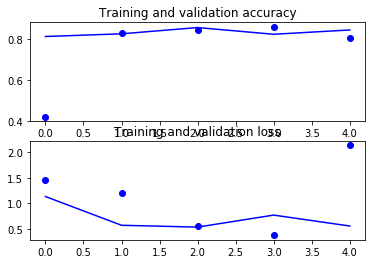

In [8]:
history = lin_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=5, # epoch_count
    validation_data=valid_generator,
    validation_steps=v_steps
    )

# Save model
lin_model.save_weights(os.path.join(RESULTS_DIR,'fedreg_lin_model.h5'))

# Plot (and save) model performance
plot_save_history(history.history, os.path.join(RESULTS_DIR,'lin_model.png'))

In [11]:
conv_model = Sequential([
            BatchNormalization(axis=1, input_shape=input_shape),
            Conv2D(32,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Conv2D(64,(3,3), activation='relu'),
            BatchNormalization(axis=1),
            MaxPooling2D((3,3)),
            Flatten(),
            Dropout(0.5),
            Dense(128, activation='relu'),
            BatchNormalization(),
            Dense(output_dim, activation='sigmoid') # 'softmax'
        ])

conv_model.compile(Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history1 = conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=2, # epoch_count
    validation_data=valid_generator,
    validation_steps=v_steps
                   )

conv_model.optimizer.lr = 1e-5
history2 = conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=2, # epoch_count
    validation_data=valid_generator,
    validation_steps=v_steps
                   )

Epoch 1/2
38/38 [==============================] - 73s - loss: 0.3059 - acc: 0.8871 - val_loss: 0.7340 - val_acc: 0.4871
Epoch 2/2
38/38 [==============================] - 72s - loss: 0.1553 - acc: 0.9416 - val_loss: 0.5915 - val_acc: 0.6000
Epoch 1/2
38/38 [==============================] - 73s - loss: 0.1070 - acc: 0.9630 - val_loss: 0.4813 - val_acc: 0.7065
Epoch 2/2
38/38 [==============================] - 72s - loss: 0.1006 - acc: 0.9634 - val_loss: 0.3809 - val_acc: 0.7806


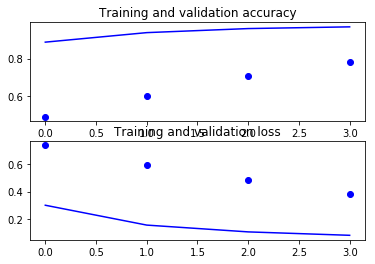

In [12]:
# Concatenate model histories together
vals = [history1.history[x]+history2.history[x] for x in history1.history.keys()]
big_hist = dict(zip(history1.history.keys(), vals))

# Save model
conv_model.save_weights(os.path.join(RESULTS_DIR,'fedreg_conv_model.h5'))

# Plot (and save) model performance
plot_save_history(big_hist, os.path.join(RESULTS_DIR,'conv_model.png'))

Instantiate the VGG16 convolutional base

In [14]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=input_shape)

conv_base.trainable = False # Freeze the convolutional base

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

Add a densely-connected classifier on top of the convolutional base

In [15]:
pt_froz_conv_model = Sequential()
pt_froz_conv_model.add(conv_base)
pt_froz_conv_model.add(Flatten())
pt_froz_conv_model.add(Dense(256, activation='relu'))
pt_froz_conv_model.add(Dense(output_dim, activation='sigmoid')) # Dense(11, activation='sigmoid')

pt_froz_conv_model.summary()

pt_froz_conv_model.compile(optimizer=Adam(lr=1e-4), # RMSprop(lr=1e-3),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               8388864   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 23,103,809
Trainable params: 8,389,121
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
pt_froz_conv_model.optimizer.lr = 1e-4
history = pt_froz_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=5,
    validation_data=valid_generator,
    validation_steps=v_steps
                   )

Epoch 1/5
38/38 [==============================] - 56s - loss: 0.1707 - acc: 0.9177 - val_loss: 0.1063 - val_acc: 0.9677
Epoch 2/5
38/38 [==============================] - 52s - loss: 0.0977 - acc: 0.9671 - val_loss: 0.0427 - val_acc: 0.9871
Epoch 3/5
38/38 [==============================] - 52s - loss: 0.0298 - acc: 0.9893 - val_loss: 0.0584 - val_acc: 0.9935
Epoch 4/5
38/38 [==============================] - 52s - loss: 0.0593 - acc: 0.9860 - val_loss: 0.1089 - val_acc: 0.9677
Epoch 5/5
38/38 [==============================] - 52s - loss: 0.0670 - acc: 0.9852 - val_loss: 0.0639 - val_acc: 0.9742


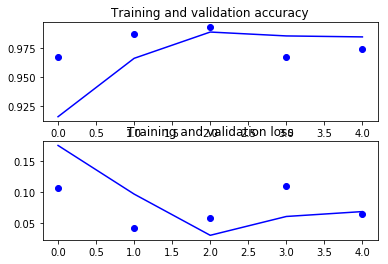

In [17]:
# Save model
pt_froz_conv_model.save_weights(os.path.join(RESULTS_DIR,'fedreg_pt_froz_conv_model.h5'))

# Plot (and save) model performance
plot_save_history(history.history, os.path.join(RESULTS_DIR, 'pt_froz_conv_model.png'))

In [18]:
# Un-freeze the convolutional base
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:        
        layer.trainable = False

pt_conv_model = Sequential()
pt_conv_model.add(conv_base)
pt_conv_model.add(Flatten())
pt_conv_model.add(Dense(128, activation='relu'))
pt_conv_model.add(Dense(output_dim, activation='sigmoid', kernel_regularizer=l2(0.01)))

pt_conv_model.compile(optimizer=RMSprop(lr=1e-4), # Adam(lr=1e-3),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

Pre-trained convolutional network, un-frozen convolutional base

Epoch 1/3
38/38 [==============================] - 45s - loss: 0.0786 - acc: 0.9720 - val_loss: 0.0468 - val_acc: 0.9935
Epoch 2/3
38/38 [==============================] - 38s - loss: 0.0518 - acc: 0.9934 - val_loss: 0.0419 - val_acc: 0.9871
Epoch 3/3
38/38 [==============================] - 38s - loss: 0.0343 - acc: 0.9975 - val_loss: 0.0511 - val_acc: 0.9903
Epoch 1/3
38/38 [==============================] - 43s - loss: 0.0531 - acc: 0.9942 - val_loss: 0.0446 - val_acc: 0.9935
Epoch 2/3
38/38 [==============================] - 38s - loss: 0.0215 - acc: 1.0000 - val_loss: 0.0770 - val_acc: 0.9935
Epoch 3/3
38/38 [==============================] - 38s - loss: 0.0361 - acc: 0.9967 - val_loss: 0.0382 - val_acc: 0.9935


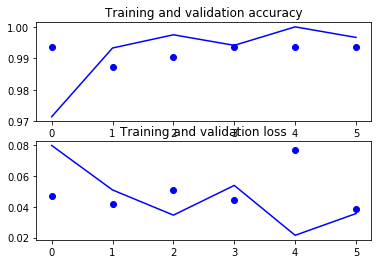

In [20]:
pt_conv_model.optimizer.lr = 1e-4
history1 = pt_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=3, # epoch_count
    validation_data=valid_generator,
    validation_steps=v_steps
                   )
pt_conv_model.optimizer.lr = 1e-5
history2 = pt_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size,
    epochs=3,
    validation_data=valid_generator,
    validation_steps=v_steps
                   )

# Concatenate model histories together
vals = [history1.history[x]+history2.history[x] for x in history1.history.keys()]
big_hist = dict(zip(history1.history.keys(), vals))

# Save model
pt_conv_model.save_weights(os.path.join(RESULTS_DIR,'fedreg_pt_conv_model.h5'))

# Plot (and save) model performance
plot_save_history(big_hist, os.path.join(RESULTS_DIR, 'pt_conv_model.png'))

Pre-trained convolutional network with drop-out, partially un-frozen convolutional base

In [21]:
# Add drop-out
pt_dr_conv_model = Sequential()
pt_dr_conv_model.add(conv_base)
pt_dr_conv_model.add(Flatten())
pt_dr_conv_model.add(Dropout(0.5))
pt_dr_conv_model.add(Dense(256, activation='relu'))
pt_dr_conv_model.add(Dense(output_dim, activation='sigmoid', kernel_regularizer=l2(0.01))) # Dense(11, activation='sigmoid')

pt_dr_conv_model.compile(optimizer=RMSprop(lr=1e-4), # Adam(lr=1e-3),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [22]:
pt_dr_conv_model.optimizer.lr = 1e-4
history1 = pt_dr_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=5, # epoch_count
    validation_data=valid_generator,
    validation_steps=v_steps
                   )
pt_dr_conv_model.optimizer.lr = 1e-5
history2 = pt_dr_conv_model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=5,
    validation_data=valid_generator,
    validation_steps=v_steps
                   )

Epoch 1/5
38/38 [==============================] - 43s - loss: 0.0688 - acc: 0.9852 - val_loss: 0.0655 - val_acc: 0.9935
Epoch 2/5
38/38 [==============================] - 38s - loss: 0.0584 - acc: 0.9926 - val_loss: 0.0335 - val_acc: 0.9968
Epoch 3/5
38/38 [==============================] - 38s - loss: 0.0285 - acc: 0.9959 - val_loss: 0.0237 - val_acc: 1.0000
Epoch 4/5
38/38 [==============================] - 38s - loss: 0.0358 - acc: 0.9975 - val_loss: 0.0887 - val_acc: 0.9903
Epoch 5/5
38/38 [==============================] - 38s - loss: 0.0259 - acc: 0.9984 - val_loss: 0.0729 - val_acc: 0.9935
Epoch 1/5
38/38 [==============================] - 43s - loss: 0.0180 - acc: 1.0000 - val_loss: 0.0342 - val_acc: 0.9968
Epoch 2/5
38/38 [==============================] - 38s - loss: 0.0611 - acc: 0.9959 - val_loss: 0.0314 - val_acc: 0.9968
Epoch 3/5
38/38 [==============================] - 38s - loss: 0.0212 - acc: 0.9975 - val_loss: 0.0607 - val_acc: 0.9935
Epoch 4/5
38/38 [===============

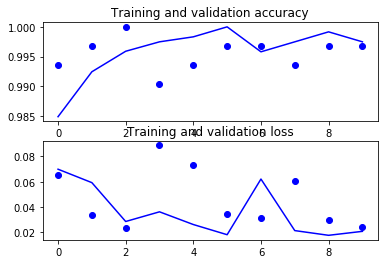

In [23]:
# Concatenate model histories together
vals = [history1.history[x]+history2.history[x] for x in history1.history.keys()]
big_hist = dict(zip(history1.history.keys(), vals))

# Save model weights
pt_dr_conv_model.save_weights(os.path.join(RESULTS_DIR,'fedreg_pt_dr_conv_model.h5'))

# Plot (and save) model performance
plot_save_history(big_hist, os.path.join(RESULTS_DIR, 'pt_dr_conv_model.png'))

In [13]:
# Load model weights
pt_dr_conv_model.load_weights(os.path.join(RESULTS_DIR,'fedreg_pt_dr_conv_model.h5'))

### Visualize convnet filter

In [24]:
pt_dr_conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 23,103,809
Trainable params: 15,468,545
Non-trainable params: 7,635,264
_________________________________________________________________


In [25]:
from keras import backend as K

model = pt_dr_conv_model

# Define the loss tensor for filter visualization
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor
grads = K.gradients(loss, model.input)[0] # Add 1e-5 before dividing so as to avoid accidentally dividing by 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [26]:
# Define a Keras function for fetching Numpy output values, given Numpy input values
iterate = K.function([model.input], [loss, grads])
# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1,)+input_shape)])

In [27]:
# Maximize loss via stochastic gradient descent over the input parameters
# We start from a gray image with some noise
input_img_data = np.random.random((1,)+input_shape) * 20 + 128.
# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step
    
# Utility function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=input_shape[0]):
    # Build a loss function that maximizes the activation of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]
    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    img = input_img_data[0]
    return deprocess_image(img)

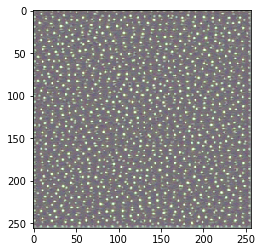

In [28]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Generate grid of all filter response patterns in a layer

In [29]:
def plot_filters(layer_name):
    size = input_shape[0]
    margin = 5

    rows = 5
    cols = 5

    # Create an empty (black) image where we will store our results
    results = np.zeros((rows * size + (rows-1) * margin, cols * size + (cols-1) * margin, 3))
    for i in range(rows):
        # Iterate over the rows of our results grid
        for j in range(cols):
            # Iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * cols), size=size)
            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(10, 10))
    plt.imshow(results)
    plt.savefig(RESULTS_DIR+layer_name+'.png')
    plt.show()

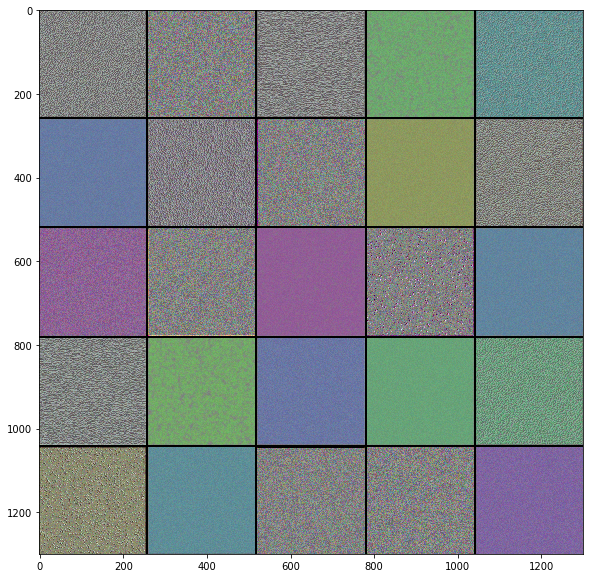

In [30]:
layer_name = 'block1_conv1'
plot_filters(layer_name)

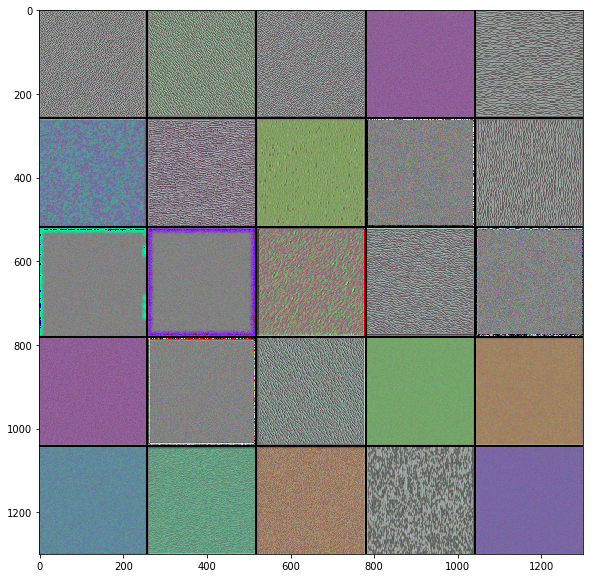

In [31]:
layer_name = 'block1_conv2'
plot_filters(layer_name)

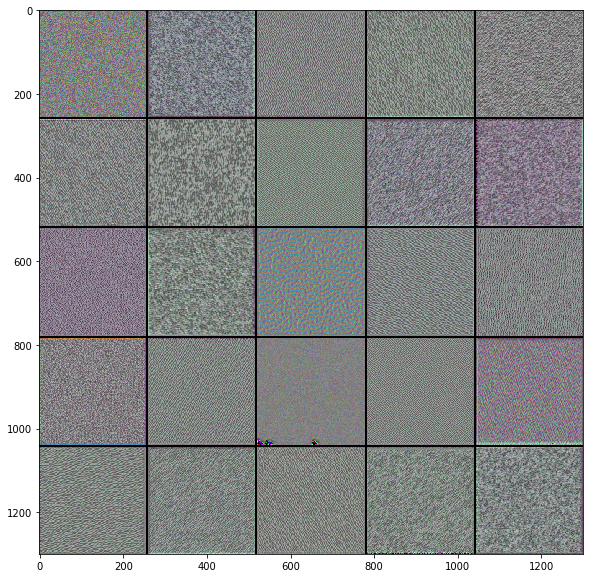

In [32]:
layer_name = 'block2_conv1'
plot_filters(layer_name)

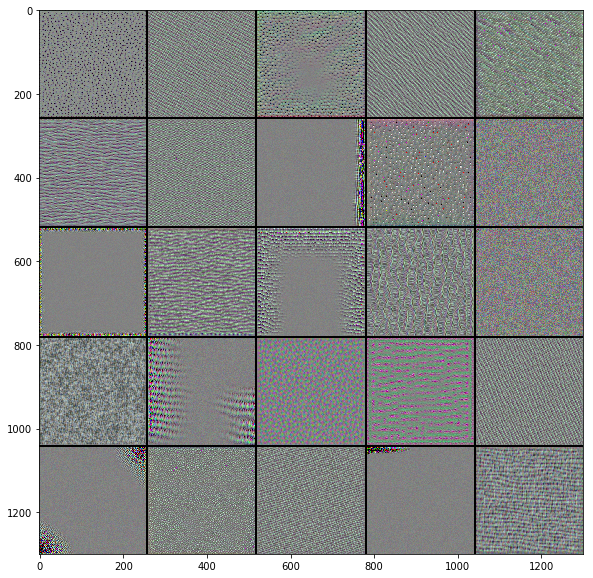

In [33]:
layer_name = 'block3_conv1'
plot_filters(layer_name)

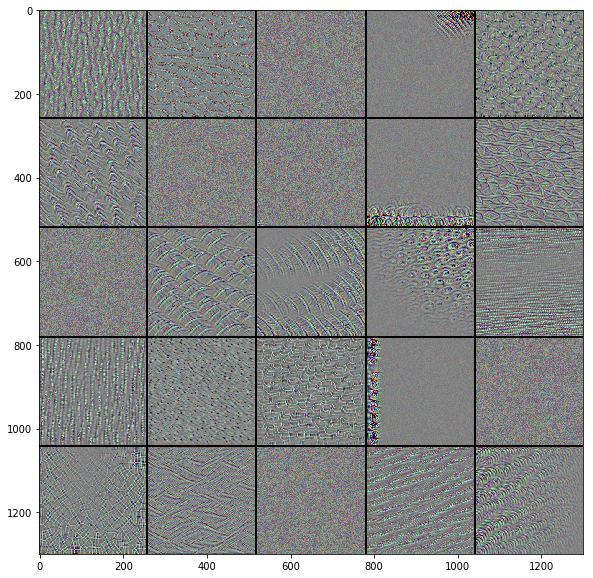

In [34]:
layer_name = 'block4_conv1'
plot_filters(layer_name)

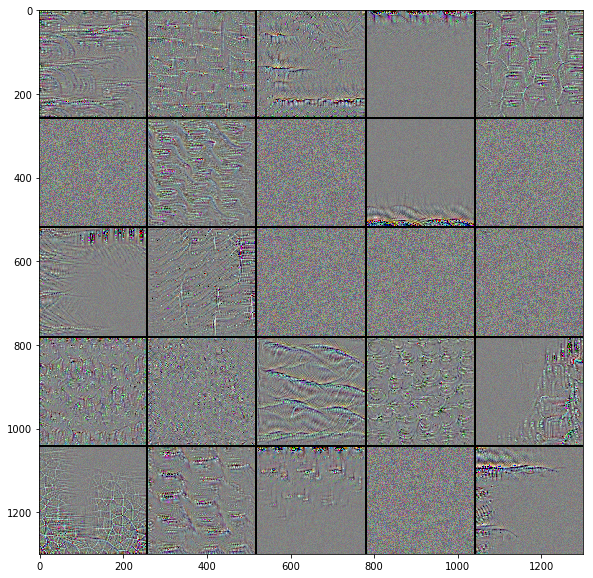

In [35]:
layer_name = 'block5_conv1'
plot_filters(layer_name)

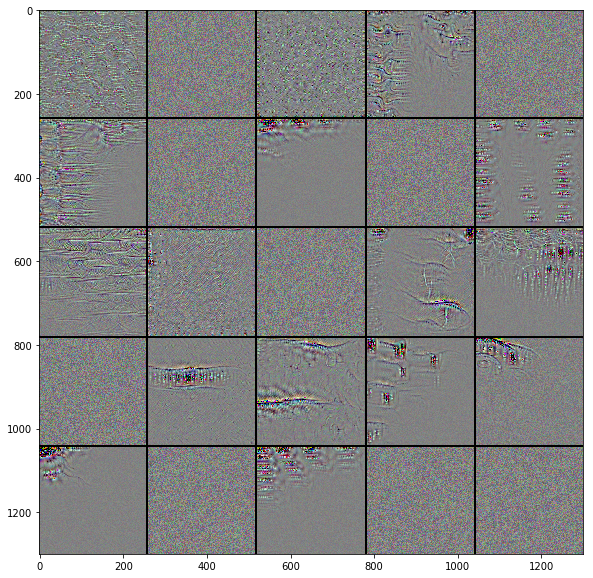

In [36]:
layer_name = 'block5_conv2'
plot_filters(layer_name)

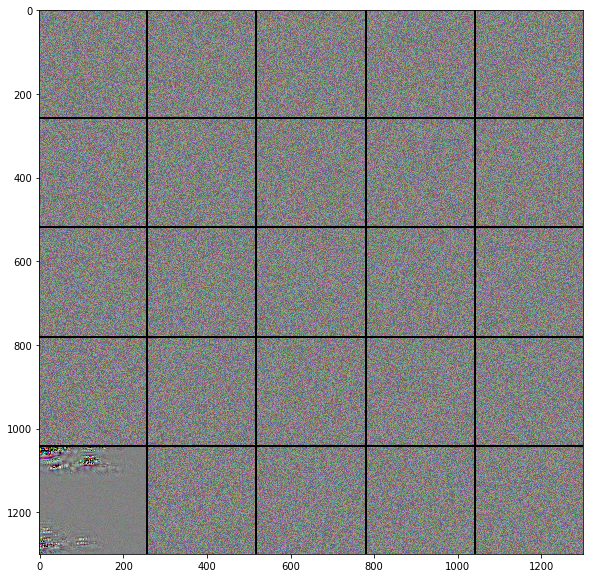

In [37]:
layer_name = 'block5_conv3'
plot_filters(layer_name)

### Generate confusion matrix

In [108]:
inverted_dict = dict([[v,k] for k,v in straight_generator.class_indices.items()])
print(inverted_dict)

#rot_dict = dict([[v,'rotated'] if 'rotated' in k else [v,'not-rotated'] 
#                 for k,v in straight_generator.class_indices.items()])
#print(rot_dict)

{0: 'diagram', 1: 'diagram_rotated', 2: 'equation_text', 3: 'equations', 4: 'forms', 5: 'graphs', 6: 'maps', 7: 'tables', 8: 'tables_rotated', 9: 'text', 10: 'text_rotated'}
{0: 'not-rotated', 1: 'rotated', 2: 'not-rotated', 3: 'not-rotated', 4: 'not-rotated', 5: 'not-rotated', 6: 'not-rotated', 7: 'not-rotated', 8: 'rotated', 9: 'not-rotated', 10: 'rotated'}


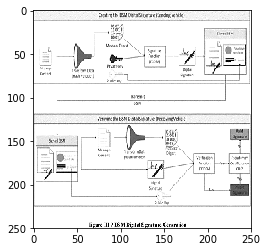

diagram
214/214 [==============================] - 131s    


In [44]:
import matplotlib.pyplot as plt
import numpy as np

inverted_dict = dict([[v,k] for k,v in straight_generator.class_indices.items()])

(im_vals,class_val) = straight_generator.next()

class_names = straight_generator.class_indices.keys()

plt.imshow(im_vals[1])
plt.show()

y_test = [inverted_dict[x] for x in np.argmax(class_val,axis=1).tolist()]

print(y_test[0])

y_pred = [inverted_dict[x] for x in pt_dr_conv_model.predict_classes(im_vals).tolist()]



In [58]:
#print(zip(y_test, y_pred))
print(len(y_test),len(y_pred))
[a==b for a, b in zip(y_test, y_pred)]


(214, 214)


[True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 T

In [60]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
fig = plt.gcf()
fig.set_size_inches(32, 32)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.cool)
plt.savefig(os.path.join(RESULTS_DIR,'conf_matrix.png')) # , figsize=(5, 5), dpi=150

Confusion matrix, without normalization
[[ 8  0  0  0  0  0  1  1  1  0  0]
 [ 0  9  0  0  0  0  0  0  2  0  0]
 [ 0  0 12  0  0  0  0  0  0  2  0]
 [ 0  0  2 31  0  0  0  1  0  1  0]
 [ 0  0  0  0 13  2  0  2  0  3  0]
 [ 0  0  0  0  0 15  0  1  1  0  0]
 [ 0  0  0  0  1  2 15  0  0  0  0]
 [ 0  0  0  0  0  0  0 24  2  1  0]
 [ 0  0  0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  2  0  0  1  1 13  0]
 [ 0  0  0  0  0  0  0  0  2  0 15]]


In [32]:
[0,90][np.random.randint(2)]

0

In [ ]:
# https://github.com/d4nst/RotNet

class RotNetDataGenerator(Iterator):

    def __init__(self, input, batch_size=64,
                 preprocess_func=None, shuffle=False):

        self.images = input
        self.batch_size = batch_size
        self.input_shape = self.images.shape[1:]
        self.preprocess_func = preprocess_func
        self.shuffle = shuffle
        # add dimension if the images are greyscale
        if len(self.input_shape) == 2:
            self.input_shape = self.input_shape + (1,)
        N = self.images.shape[0]

        super(RotNetDataGenerator, self).__init__(N, batch_size, shuffle, None)

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array, _, current_batch_size = next(self.index_generator)

        # create array to hold the images
        batch_x = np.zeros((current_batch_size,) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros(current_batch_size, dtype='float32')

        # iterate through the current batch
        for i, j in enumerate(index_array):
            image = self.images[j]

            # get a random angle
            rotation_angle = np.random.randint(360)

            # rotate the image
            rotated_image = rotate(image, rotation_angle)

            # add dimension to account for the channels if the image is greyscale
            if rotated_image.ndim == 2:
                rotated_image = np.expand_dims(rotated_image, axis=2)

            # store the image and label in their corresponding batches
            batch_x[i] = rotated_image
            batch_y[i] = rotation_angle

        # convert the numerical labels to binary labels
        batch_y = to_categorical(batch_y, 360)

        # preprocess input images
        if self.preprocess_func:
            batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

In [ ]:
# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

nb_train_samples, img_rows, img_cols, img_channels = X_train.shape
input_shape = (img_rows, img_cols, img_channels)
nb_test_samples = X_test.shape[0]

# model definition
input = Input(shape=(img_rows, img_cols, img_channels))
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                  activation='relu')(input)
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                  activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(nb_classes, activation='softmax')(x)

model = Model(input=input, output=x)

Instantiate resnet model

In [42]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.applications.resnet50 import ResNet50

# load base model
base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=input_shape)

In [43]:
# number of classes
nb_classes = 1

# append classification layer
x = base_model.output
x = Flatten()(x)
final_output = Dense(nb_classes, activation='sigmoid', name='fc90')(x)

# create the new model
model = Model(input=base_model.input, output=final_output)

# model compilation
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fc..., inputs=Tensor("in...)`
  # Remove the CWD from sys.path while we load stuff.


In [44]:
# callbacks
checkpointer = ModelCheckpoint(
    filepath=RESULTS_DIR+'resnet_weights.h5',
    save_best_only=True
)
early_stopping = EarlyStopping(patience=2)
tensorboard = TensorBoard()
# model_checkpoint = ModelCheckpoint(results_path+'weights.h5', monitor='val_loss', save_best_only=True)

In [ ]:
#model.optimizer.lr = 1e-5

model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n/batch_size, # Number of unique samples of your dataset over batch size
    epochs=5, # epoch_count
    validation_data=valid_generator,
    validation_steps=v_steps,
    callbacks=[checkpointer, early_stopping, tensorboard]
                   )

Epoch 1/5
38/38 [==============================] - 51s - loss: 0.0616 - acc: 0.9786 - val_loss: 0.6927 - val_acc: 0.6032
Epoch 2/5
38/38 [==============================] - 52s - loss: 0.1043 - acc: 0.9603 - val_loss: 0.6765 - val_acc: 0.5129
Epoch 3/5
11/38 [=======>......................] - ETA: 17s - loss: 0.0841 - acc: 0.9744